In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

plt.style.use('ggplot')
%matplotlib inline

In [2]:
IMG_BASE = '../../content/images/boardgames/'

games = pd.read_pickle('data/boardgame_clean.pkl')

We hvae already cleaned and standardized the data. We have still included games with relatively few ratings (these will be the ones shrunk most effectively) but  have removed any games with fewer than 30 ratings before determining the mean and standard deviation for the distribution of _average ratings_.

Best fit mean = 6.243212717004798; best fit std deviation is 0.8997


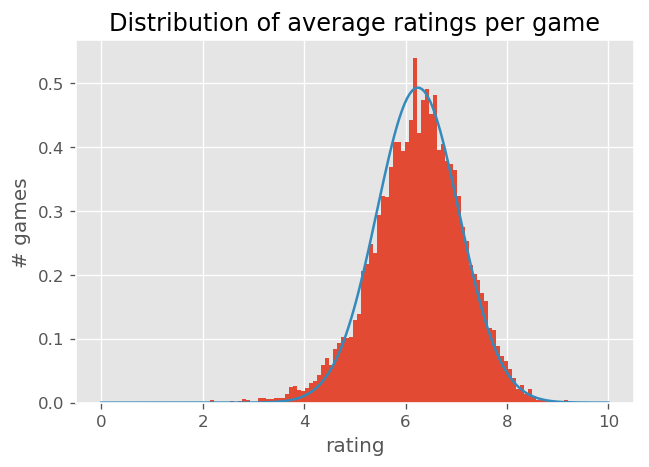

In [3]:
MIN_USERS_TO_COUNT = 30
mask_enough_ratings = (games['users_rated'] > MIN_USERS_TO_COUNT)

moment_subset = games.loc[mask_enough_ratings, 'average_rating']

pop_mean = moment_subset.mean()
pop_var = moment_subset.var()

X = np.linspace(0, 10, 200)

plt.figure(dpi=120)
plt.hist(moment_subset, bins=100, normed=True)
plt.plot(X, norm.pdf(X, pop_mean, pop_var))
plt.xlabel('rating')
plt.ylabel('# games')
plt.title('Distribution of average ratings per game');
print(f'Best fit mean = {pop_mean}; best fit std deviation is {np.sqrt(pop_var):6.4f}')

plt.savefig(IMG_BASE + 'raw_dist.png')

Now let's see how this changes with sample size.

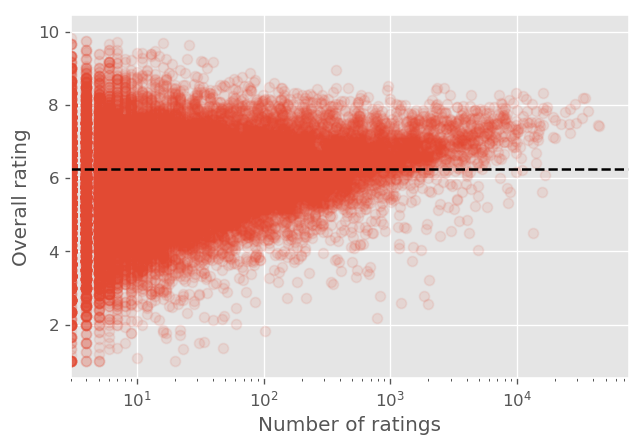

In [4]:
plt.figure(dpi=120)

plt.semilogx(games['users_rated'], games['average_rating'], marker='o', linestyle='None', alpha=0.1)

plt.xlim(3,)
plt.xlabel('Number of ratings')
plt.ylabel('Overall rating')
plt.gca().axhline(pop_mean, c='k', linestyle='--');
plt.savefig(IMG_BASE + 'rating_vs_popularity_raw.png')

Ok, we now have the distribution of observed means $\bar{x}_i$. We will take this to be our prior distribution for the actual rating for the game, $\theta_i$:
$$P(\theta_i) \propto \exp(-(\theta_i - \mu)^2/2\tau^2)$$

where $\mu$=`pop_mean` and $tau^2$=`pop_var`

The central limit theorem tells us the sample mean (i.e. the average rating of a game) will follow a normal distribution around the true mean for that game, $\theta_i$:
$$P(\bar{x}_i |\theta_i) \propto \exp(-(\bar{x}_i - \theta_i)^2/2\sigma_{\bar{x}_i}^2)$$

where 
$$\sigma_{\bar{x}_i}^2 = \frac{\text{variance for game i}}{\text{number of reviews for game i}}$$

Because this notation is cumbersome, let's define
$$S_i^2 = \sigma_{\bar{x}_i}^2$$

#### Bayes's theorem

We know $\bar{x}_i$ and want to infer $\theta_i$. Bayes's theorem to the rescue!

$$P(\theta_i | \bar{x}_i) \propto P(\bar{x}_i | \theta_i) P(\theta_i)$$

This gives us
$$P(\theta_i | \bar{x}_i) \propto \exp(- Z )$$
where
$$Z= \frac{(\bar{x}_i - \theta_i)^2}{S_i^2} + \frac{(\theta_i - \mu)^2}{\tau^2}$$
Completing the square, we have
$$Z = \left(\frac{1}{S_i^2} + \frac{1}{\tau^2}\right)\left(\theta_i^2 - 2\left[\frac{\bar{x}_i \tau^2 + \mu S_i^2}{S_i^2 + \tau^2}\right]\theta_i\right) + \text{const} = \left(\frac{1}{S_i^2} + \frac{1}{\tau^2}\right)\left(\theta_i - \left[\frac{\bar{x}_i \tau^2 + \mu S_i^2}{S_i^2 + \tau^2}\right]\right)^2 + \text{const}$$
This quantity is minimized when the quadratic term is zero, i.e.
$$\theta = \left[\frac{\bar{x}_i \tau^2 + \mu S_i^2}{S_i^2 + \tau^2}\right] = \left(\frac{\tau^2}{\tau^2 + S_i^2}\right) \bar{x}_i^2 + \left(\frac{S_i^2}{\tau^2 + S_i^2}\right)\mu$$
Put another way:
$$\theta = B \bar{x}_i + (1-B) \mu, \quad\quad B = \frac{\tau^2}{\tau^2 + S_i^2}$$

i.e. when $\tau^2 \gg S_i^2$, $B \approx 1$ and the main contribution is the observed average. When $S_i^2 \gg \tau^2$, $B \approx 0$ and the main contribution is the global average $\mu$. Since $S_i \rightarrow 0$ as the number of reviews goes to infinity, this matches the intuition that shrinkage should affect games with fewer reviews more.

In [5]:
games['rating_stddev'] = games['rating_stddev'].fillna(3e6)

In [6]:
games['B'] = pop_var/(pop_var + (games['rating_stddev']**2/games['users_rated']))
games['shrunk_rating'] = games['B']*games['average_rating'] + (1-games['B'])*pop_mean

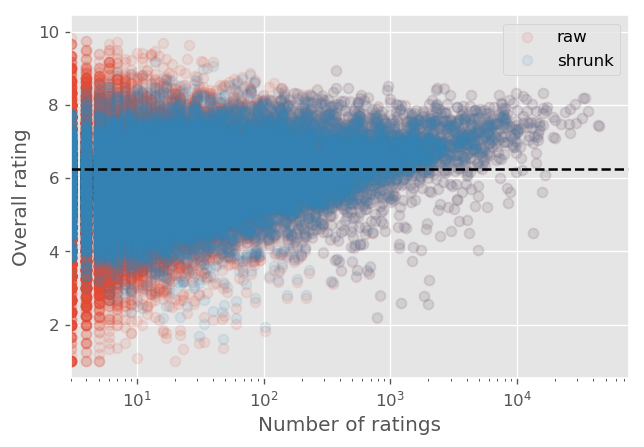

In [7]:
plt.figure(dpi=120)

plt.semilogx(games['users_rated'], games['average_rating'], marker='o', linestyle='None', alpha=0.1, label='raw')
plt.semilogx(games['users_rated'], games['shrunk_rating'], marker='o', linestyle='None', alpha=0.1, label='shrunk')

plt.xlim(3,)
plt.xlabel('Number of ratings')
plt.ylabel('Overall rating')
plt.legend()
plt.gca().axhline(pop_mean, c='k', linestyle='--');
plt.savefig(IMG_BASE + 'rating_vs_popularity_shrunk.png')

Best fit mean = 6.243212717004798; best fit std deviation is 0.8997


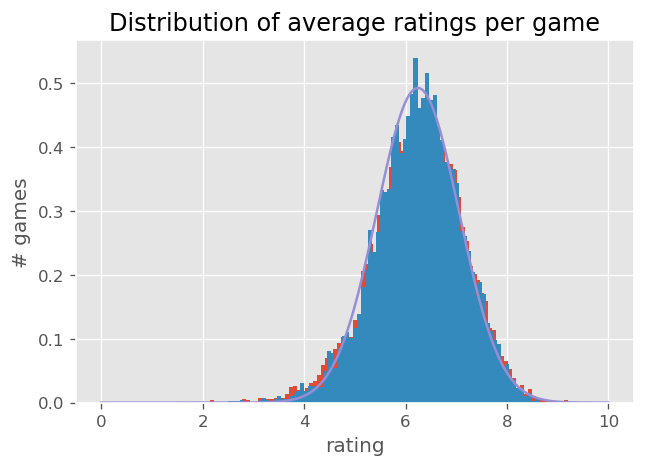

In [8]:
MIN_USERS_TO_COUNT = 30
mask_enough_ratings = (games['users_rated'] > MIN_USERS_TO_COUNT)

moment_subset = games.loc[mask_enough_ratings, 'average_rating']

pop_mean = moment_subset.mean()
pop_var = moment_subset.var()

X = np.linspace(0, 10, 200)

plt.figure(dpi=120)
plt.hist(moment_subset, bins=100, normed=True)
plt.hist(games.loc[mask_enough_ratings, 'shrunk_rating'].dropna(), bins=100, normed=True)
plt.plot(X, norm.pdf(X, pop_mean, pop_var))
plt.xlabel('rating')
plt.ylabel('# games')
plt.title('Distribution of average ratings per game');
print(f'Best fit mean = {pop_mean}; best fit std deviation is {np.sqrt(pop_var):6.4f}')

In [9]:
games.head()

,name,year_published,min_players,max_players,playingtime,min_age,users_rated,average_rating,rating_stddev,boardgamefamilies,B,shrunk_rating
0,Die Macher,1986,3,5,240,14,3973,7.71006,1.56772,"10643,91",0.999236,7.708940
1,Dragonmaster,1981,3,4,30,12,405,6.60742,1.45377,7005,0.993595,6.605087
2,Samurai,1998,2,4,45,10,9847,7.44860,1.19943,"9470,10634,42",0.999820,7.448383
3,Tal der Könige,1992,2,4,60,12,286,6.64937,1.19351,"6471,11505",0.993885,6.646886
4,Acquire,1962,3,6,90,12,12031,7.39447,1.32372,4891,0.999820,7.394263


In [10]:
games[games.users_rated < 100]

,name,year_published,min_players,max_players,playingtime,min_age,users_rated,average_rating,rating_stddev,boardgamefamilies,B,shrunk_rating
5,Mare Mediterraneum,1989,2,6,240,12,64,6.54219,1.693170e+00,NaN,9.475689e-01,6.526514
20,Gateway to the Stars,1981,1,7,0,12,25,5.20000,1.600000e+00,NaN,8.877129e-01,5.317139
28,Terrain Vague,1993,2,4,120,10,57,6.59035,1.466930e+00,22783,9.554440e-01,6.574883
35,Runes,1981,2,4,30,10,75,6.07333,1.343360e+00,NaN,9.711357e-01,6.078234
36,Darkover,1979,2,4,60,12,86,5.21163,1.828930e+00,NaN,9.541570e-01,5.258921
50,Brauerei,1996,3,6,0,14,26,5.86346,1.382830e+00,NaN,9.167169e-01,5.895087
52,Sophie's World,1998,2,6,0,12,55,4.78364,1.695640e+00,NaN,9.393423e-01,4.872174
61,The Garden Game,1996,2,6,30,8,16,3.93750,1.297530e+00,NaN,8.849725e-01,4.202720
65,Bollox,1999,2,2,20,10,32,6.76406,1.083560e+00,"5902,6485,4220",9.566426e-01,6.741477
97,Peaceful Resistance,1995,2,3,30,0,16,5.58125,1.501760e+00,NaN,8.517047e-01,5.679416
